### Hotspot Profiles

These are usually computed internally within the modified szifi code. Here, we'll compute the profile explicitly. 

In [23]:
%pylab inline
from scipy.special import spherical_jn,sici,lpmn
import camb
from scipy import integrate

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load camb
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.32, ombh2=0.022383, omch2=0.12011,tau=0.0543,mnu=0.06,omk=0,standard_neutrino_neff=True)
As = 1e-10*np.exp(3.0448)
pars.InitPower.set_params(ns=0.96605,r=0.,pivot_scalar=0.05,As=As)

DeltaSq_zeta = As*2*np.pi**2 # primordial amplitude (from Planck)
H2_dotphi = np.sqrt(As*4.*np.pi**2.) # H^2 / dot{phi} in inflation [if scale invariant]

In [32]:
# Load precomputed transfer function from file
transfer = np.load('camb_output3500.npz')

# Resolution parameters
reduce_k = 10
lmax = 3500
kmin = 1e-6
kmax = 1

# Restrict transfer function to relevant range
k = transfer['k'][::reduce_k]
filt_k = (k>kmin)*(k<kmax)
transfer_k = k[filt_k]
transfer_l = transfer['l'][:lmax-1]
transferT_func = transfer['transfer'][0][:lmax-1,::reduce_k][:,filt_k] # T-modes
transferE_func = transfer['transfer'][1][:lmax-1,::reduce_k][:,filt_k] # E-modes
transferE_func *= np.sqrt((transfer_l + 2) * (transfer_l + 1) * transfer_l * (transfer_l - 1))

/tmp/ipykernel_49902/787372968.py:17: RuntimeWarning: invalid value encountered in sqrt
  transferE_func *= np.sqrt((transfer_l + 2) * (transfer_l + 1) * transfer_l * (transfer_l - 1))


ValueError: operands could not be broadcast together with shapes (3499,1994) (3499,) (3499,1994) 

In [18]:
# Compute distance to last scattering (or peak thereof)
back = camb.get_background(pars)
eta_rec = back.tau_maxvis # comoving horizon at last-scattering
eta_0 = back.tau0 # comoving horizon today

# Model parameters
eta_star = 100.
eta_hs = 250.
        
# Define maximum scale
theta_max = np.max([0.1,np.sqrt(4.*np.pi)*np.asarray(eta_star)/eta_0])
            
# Input theta array
theta_vec = np.linspace(0.,theta_max,1000)

In [21]:
print("Computing hotspot profile with n_l: %d, n_k: %d"%(len(transfer_l),len(transfer_k)))

# Compute all Legendre polynomials
all_legs = np.stack([lpmn(0,max(transfer_l),np.cos(theta))[0].ravel() for theta in theta_vec]).T[2:]

# Compute all Bessel functions
bessels = spherical_jn(transfer_l[:,None],transfer_k*(eta_0-eta_hs))

Computing hotspot profile with n_l: 3499, n_k: 1994


NameError: name 'integrate' is not defined

In [42]:
# Define profile function
fx_over_g = lambda x: H2_dotphi*(sici(x)[0]-np.sin(x))
            
# Perform k integral
k_integT = integrate.simpson(bessels*transferT_func*fx_over_g(transfer_k*eta_star)/transfer_k,x=transfer_k)/(2.*np.pi**2.)
k_integE = integrate.simpson(bessels*transferE_func*fx_over_g(transfer_k*eta_star)/transfer_k,x=transfer_k)/(2.*np.pi**2.)

# Perform ell sum
profileT = np.sum(((2.*transfer_l+1.)*k_integT)[:,None]*all_legs,axis=0)
profileE = np.sum(((2.*transfer_l+1.)*k_integE)[:,None]*all_legs,axis=0)

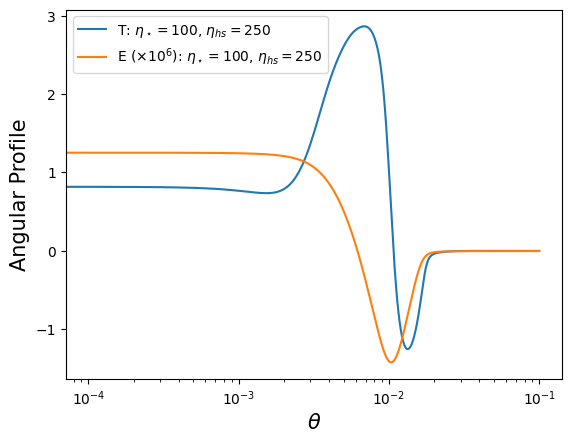

In [43]:
plt.plot(theta_vec, 1e6*profileT, label=r'T: $\eta_\star = %d$, $\eta_{hs} = %d$'%(eta_star,eta_hs));
plt.plot(theta_vec, 1e12*profileE, label=r'E ($\times 10^6$): $\eta_\star = %d$, $\eta_{hs} = %d$'%(eta_star,eta_hs));
plt.xlabel(r'$\theta$',fontsize=15)
plt.ylabel(r'Angular Profile',fontsize=15);
plt.xscale('log');
plt.legend();